This notebook demonstrates how to use BTK to produce more advanced plots to evaluate a given deblender or set of deblenders.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import btk
import multiprocessing as mp

## Utility

In [ ]:
def get_psf_size(survey: btk.survey.Survey):
    psf_size_arcsec =  survey.get_filter('r').psf_fwhm.to_value('arcsec')
    pixel_scale = survey.pixel_scale.to_value('arcsec')
    return psf_size_arcsec / pixel_scale

## Setup simulation

For our simulation we use the `DefaultSamplingFunction` which randomly samples galaxies from the given catalog and places them a distance `max_shift` from the center. We use a `max_shift` of 3 arcseconds from the center of the image 
which makes blends more likely. We also limit each blend to having between 0 and 10 light sources (uniformly at random) and we limit ourselves to sources that have an `i`-band LSST magnitude between 18 and 27.

In [ ]:
max_n_sources = 10
min_n_sources = 0
stamp_size = 24.0
max_shift = 3.0 # shift from center is 3 arcsecs = 15 pixels, so blends are likely.
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../data/input_catalog.fits')

sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size, 
    max_shift=max_shift, 
    min_mag = 18, 
    max_mag = 27,
    seed = seed)

survey = btk.survey.get_surveys('LSST')

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="background",
    seed=seed, # use same seed here
)

## Example blends

In [ ]:
blend_batch = next(draw_generator)

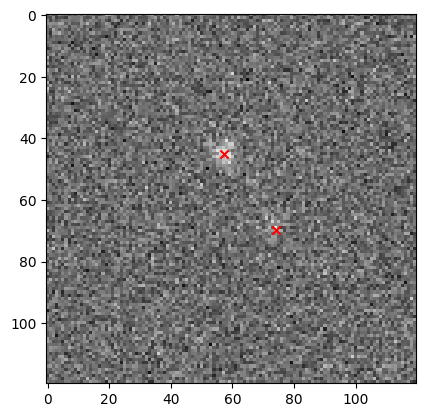

In [ ]:
import matplotlib.pyplot as plt

ii = np.random.randint(0, 100)

# plot the first blend in the batch, with the r-band
plt.imshow(blend_batch.blend_images[ii, 2, :, :], cmap="gray")

# plot centers
plt.scatter(blend_batch.catalog_list[ii]["x_peak"], 
            blend_batch.catalog_list[ii]["y_peak"], c="r", marker="x")

## Efficiency matrices using Peak-finding and SEP 

We will plot efficiency matrices comparing the peak-finding algorithm in `scikit-image` and compare it with `SEP` (source extractor in python). We will run both algorithms on the `r`-band images.

We will accumulate the results over `1000` blends. 

In [ ]:
from btk.deblend import SepSingleBand, PeakLocalMax

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey)) # needs to be an integer

thresh = 1.5
min_area = 3

# setup both deblenders
peak_finder = PeakLocalMax(max_n_sources=max_n_sources, 
                           threshold_scale=5, 
                           min_distance=min_distance, 
                           use_band=2 # r-band
                           )

sep = SepSingleBand(max_n_sources=max_n_sources, thresh=thresh, min_area=min_area, use_band=2)

In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

In [ ]:
from btk.metrics.detection import Efficiency


eff_matrix_peak= Efficiency(batch_size)
eff_matrix_sep = Efficiency(batch_size)

for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    eff_matrix_peak(matching_peak.tp, matching_peak.t, matching_peak.p)
    eff_matrix_sep(matching_sep.tp, matching_sep.t, matching_sep.p)

100%|██████████| 10/10 [01:30<00:00,  9.10s/it]


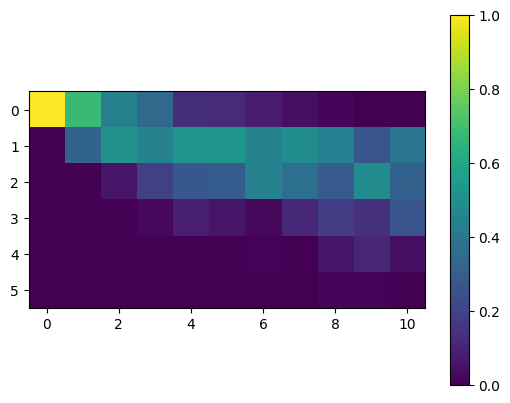

In [ ]:
mat = eff_matrix_peak.aggregate()
mat = mat / mat.sum(axis=0)
plt.imshow(mat)
plt.colorbar()

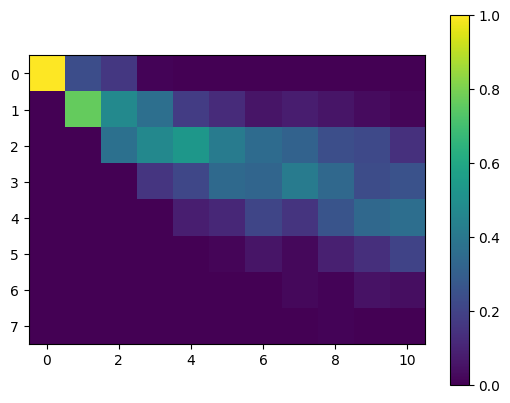

In [ ]:
mat = eff_matrix_sep.aggregate()
mat = mat / mat.sum(axis=0)
plt.imshow(mat)
plt.colorbar()

## Reconstruction metrics histograms

We compare the reconstruction from SEP with that from the Scarlet deblender, using the three reconstruction metrics implemented in BTK: MSE, PSNR, and structure similarity index. 
We again pick the `r`-band images for this comparison.

In [ ]:
from btk.metrics.reconstruction import MSE, PSNR, StructSim
from btk.match import PixelHungarianMatcher
from btk.deblend import SepSingleBand, Scarlet


metrics_sep = {'mse': MSE(batch_size), 
               'psnr': PSNR(batch_size), 
               'ssim': StructSim(batch_size)
               }

metrics_scarlet = {'mse': MSE(batch_size),
                   'psnr': PSNR(batch_size),
                   'ssim': StructSim(batch_size)
                   }

thresh = 5.0

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey))
sep = SepSingleBand(max_n_sources=max_n_sources, thresh=thresh, use_band=2)
scarlet = Scarlet(max_n_sources)
matcher = PixelHungarianMatcher(min_distance)


In [ ]:
njobs = 5 if mp.cpu_count() > 5 else mp.cpu_count() - 1


for ii in tqdm(range(10)):
    blend_batch = next(draw_generator)
    sep_batch = sep(blend_batch)
    scarlet_batch = scarlet(blend_batch, 
                            reference_catalogs=sep_batch.catalog_list, 
                            njobs=4)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)
    matching_scarlet = matcher(blend_batch.catalog_list, scarlet_batch.catalog_list) 

    true_iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    iso_images_sep = sep_batch.deblended_images[:, :, 0] # pick the single band corresponding to 'r' band
    iso_images_scarlet = scarlet_batch.deblended_images[:, :, 2] # pick 'r' band

    iso_images1 = matching_sep.match_true_arrays(true_iso_images)
    iso_images2 = matching_scarlet.match_true_arrays(true_iso_images)
    iso_images_sep = matching_sep.match_pred_arrays(iso_images_sep)
    iso_images_scarlet = matching_scarlet.match_pred_arrays(iso_images_scarlet)

    for metric in metrics_sep.values():
        metric(iso_images1, iso_images_sep)
    
    for metric in metrics_scarlet.values():
        metric(iso_images2, iso_images_scarlet)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [12:41<00:00, 76.15s/it]


In [ ]:
# join data from all batches into single array

# sep 
all_sep = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])} 
for metric_name, metric in metrics_sep.items():
    for mvalues in metric.all_data:
        all_sep[metric_name] = np.concatenate([all_sep[metric_name], mvalues[metric_name]])

# scarlet
all_scarlet = {'mse': np.array([]), 'psnr': np.array([]), 'ssim': np.array([])}
for metric_name, metric in metrics_scarlet.items():
    for mvalues in metric.all_data:
        all_scarlet[metric_name] = np.concatenate([all_scarlet[metric_name], mvalues[metric_name]])

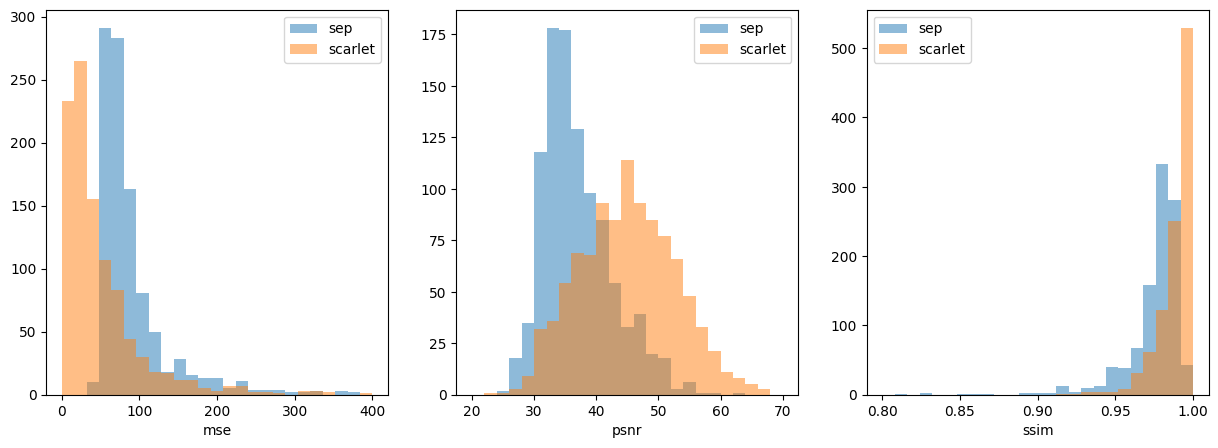

In [ ]:
# plot histograms of each metric for both deblenders 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ranges = [(0, 400), (20, 70), (0.8, 1.0)]
for ii, metric_name in enumerate(['mse', 'psnr', 'ssim']):
    ax = axes[ii]
    _, bins, _ = ax.hist(all_sep[metric_name], bins=25, alpha=0.5, label='sep', color='C0', histtype='stepfilled',  range=ranges[ii])
    ax.hist(all_scarlet[metric_name], bins=bins, alpha=0.5, label='scarlet', color='C1', histtype='stepfilled',  range=ranges[ii])
    ax.set_xlabel(metric_name)
    ax.legend()

## Precision and Recall curves

Here we compare the detection peformance of SEP and the `peak_local_max` algorithm in `scikit-image` by plotting a recall curve as a function of SNR (using the `r`-band images).

In [ ]:
from btk.deblend import SepSingleBand, PeakLocalMax

# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey)) # needs to be an integer

# setup both deblenders
peak_finder = PeakLocalMax(max_n_sources=max_n_sources+3, 
                           threshold_scale=5, 
                           min_distance=min_distance, 
                           use_band=2 # r-band
                           )

sep = SepSingleBand(max_n_sources=max_n_sources+1, thresh=1.5, min_area=3, use_band=2)


In [ ]:
from btk.match import PixelHungarianMatcher

# matcher
matcher = PixelHungarianMatcher(pixel_max_sep=min_distance
                                )

In [ ]:
from galcheat.utilities import mean_sky_level

# we will continue using 'r' band
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

In [ ]:
from btk.metrics.detection import Recall
from btk.measure import get_snr


snr_bins = np.linspace(0, 100, 21)
recalls_peaks = [Recall(batch_size) for _ in range(1, len(snr_bins))]
recalls_sep = [Recall(batch_size) for _ in range(1, len(snr_bins))]

for _ in tqdm(range(10)):
    blend_batch = next(draw_generator)
    iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    snr_r = get_snr(iso_images, sky_level)

    peak_batch = peak_finder(blend_batch)
    sep_batch = sep(blend_batch)
    matching_peak = matcher(blend_batch.catalog_list, peak_batch.catalog_list)
    matching_sep = matcher(blend_batch.catalog_list, sep_batch.catalog_list)

    for jj in range(1, len(snr_bins)):
        min_snr, max_snr = snr_bins[jj-1], snr_bins[jj]
        mask = snr_r > min_snr
        matching_peak_new = matching_peak.filter_by_true(mask)
        matching_sep_new = matching_sep.filter_by_true(mask)
        recalls_peaks[jj-1](matching_peak_new.tp, matching_peak_new.t, matching_peak_new.p)
        recalls_sep[jj-1](matching_sep_new.tp, matching_sep_new.t, matching_sep_new.p)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:30<00:00,  9.08s/it]


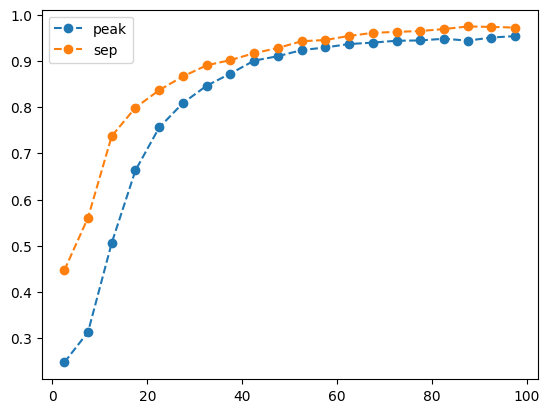

In [ ]:
mean_recalls_peaks = np.array([recall.aggregate() for recall in recalls_peaks])
mean_recalls_sep = np.array([recall.aggregate() for recall in  recalls_sep])

median_bins = (snr_bins[1:] + snr_bins[:-1]) / 2

plt.plot(median_bins, mean_recalls_peaks, '--o', label='peak', color='C0')
plt.plot(median_bins, mean_recalls_sep, '--o', label='sep', color='C1')

plt.legend()

## Ellipticity residuals for Scarlet 

Here we plot the ellipticity errors for the Scarlet deblender as a function of SNR and blendedness. We use the `r`-band images for this comparison, and we condition the deblending on true detections.

In [ ]:
from galcheat.utilities import mean_sky_level

# we will continue using 'r' band
sky_level = mean_sky_level(survey, survey.get_filter('r')).to_value('electron') # gain = 1

In [ ]:
from btk.match import PixelHungarianMatcher
from btk.deblend import Scarlet


# use psf size as minimum distance between peaks (in pixels).
min_distance = int(get_psf_size(survey))
scarlet = Scarlet(max_n_sources)
matcher = PixelHungarianMatcher(min_distance)


In [ ]:
from btk.measure import get_ksb_ellipticity, get_blendedness, get_snr

es1 = []
es2 = [] 
snrs = [] 
bs = [] 

for ii in tqdm(range(5)):
    blend_batch = next(draw_generator)
    scarlet_batch = scarlet(blend_batch, 
                            reference_catalogs=None, # uses truth catalog
                            njobs=5) 
    matching_scarlet = matcher(blend_batch.catalog_list, scarlet_batch.catalog_list) 

    psf_r = blend_batch.psf[2] # psf in r-band


    true_iso_images = blend_batch.isolated_images[:, :, 2] # pick 'r' band
    iso_images_scarlet = scarlet_batch.deblended_images[:, :, 2] # pick 'r' band

    iso_images1 = matching_scarlet.match_true_arrays(true_iso_images)
    iso_images2 = matching_scarlet.match_pred_arrays(iso_images_scarlet)

    ellips1 = get_ksb_ellipticity(iso_images1, psf_r, pixel_scale=0.2)
    ellips2 = get_ksb_ellipticity(iso_images2, psf_r, pixel_scale=0.2)

    snr = get_snr(iso_images1, sky_level)
    blendedness = get_blendedness(iso_images1)

    # aperture photometry (all colors, pick r-i, )

    es1.append(ellips1)
    es2.append(ellips2)
    snrs.append(snr)
    bs.append(blendedness)


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/imendoza/code/BlendingToolKit/btk/measure.py:69: RuntimeWarning: invalid value encountered in divide
  return 1 - num / denom
 20%|██        | 1/5 [02:06<08:27, 126.76s/it]/Users/imendoza/code/BlendingToolKit/btk/measure.py:69: RuntimeWarning: invalid value encountered in divide
  return 1 - num / denom
 40%|████      | 2/5 [04:12<06:17, 125.97s/it]/Users/imendoza/code/BlendingToolKit/btk/measure.py:69: RuntimeWarning: invalid value encountered in divide
  return 1 - num / denom
 60%|██████    | 3/5 [06:04<03:59, 119.92s/it]/Users/imendoza/code/BlendingToolKit/btk/measure.py:69: RuntimeWarning: invalid value encountered in divide
  return 1 - num / denom
 80%|████████  | 4/5 [07:59<01:57, 117.81s/it]/Users/imendoza/code/BlendingToolKit/btk/measure.py:69: RuntimeWarning: invalid value encountered in divide
  return 1 - num / denom
100%|██████████| 5/5 [10:05<00:00, 121.08s/it]


In [ ]:
from typing import Tuple
def scatter_shade_plot(
    ax: plt.Axes,
    x: np.ndarray,
    y: np.ndarray,
    xlims: Tuple[float, float],
    delta: float,
    qs: Tuple[float, float] = (0.25, 0.75),
    color: str = "#377eb8",
    alpha: float = 0.5,
):
    xbins = np.arange(xlims[0], xlims[1], delta)

    xs = np.zeros(len(xbins))
    ys = np.zeros(len(xbins))
    yqs = np.zeros((len(xbins), 2))

    for i, bx in enumerate(xbins):
        keep_x = (x > bx) & (x < bx + delta)
        y_bin: np.ndarray = y[keep_x]

        xs[i] = bx + delta / 2

        if y_bin.shape[0] == 0:
            ys[i] = np.nan
            yqs[i] = (np.nan, np.nan)
            continue

        ys[i] = np.median(y_bin)
        yqs[i, :] = np.quantile(y_bin, qs[0]), np.quantile(y_bin, qs[1])

    ax.plot(xs, ys, marker="o", c=color, linestyle="-")
    ax.fill_between(xs, yqs[:, 0], yqs[:, 1], color=color, alpha=alpha)

In [ ]:
e11 = np.concatenate(es1)[:, :, 0].flatten()
e12 = np.concatenate(es1)[:, :, 1].flatten()
e21= np.concatenate(es2)[:, :, 0].flatten()
e22= np.concatenate(es2)[:, :, 1].flatten()
snr = np.concatenate(snrs).flatten()
bdd = np.concatenate(bs).flatten()

cond1 = ~np.isnan(e11) & (e11 > -1) & (e11 < 1) 
cond2 = (~np.isnan(e12)) & (e12 > -1) & (e12 < 1)
cond3 = (~np.isnan(e21)) & (e21 > -1) & (e21 < 1)
cond4 = (~np.isnan(e22)) & (e22 > -1) & (e22 < 1)
cond5 = (snr > 0) & (snr < 100)
cond = cond1 & cond2 & cond3 & cond4 & cond5

e11 = e11[cond]
e12 = e12[cond]
e21 = e21[cond]
e22 = e22[cond]
snr = snr[cond]
bdd = bdd[cond]


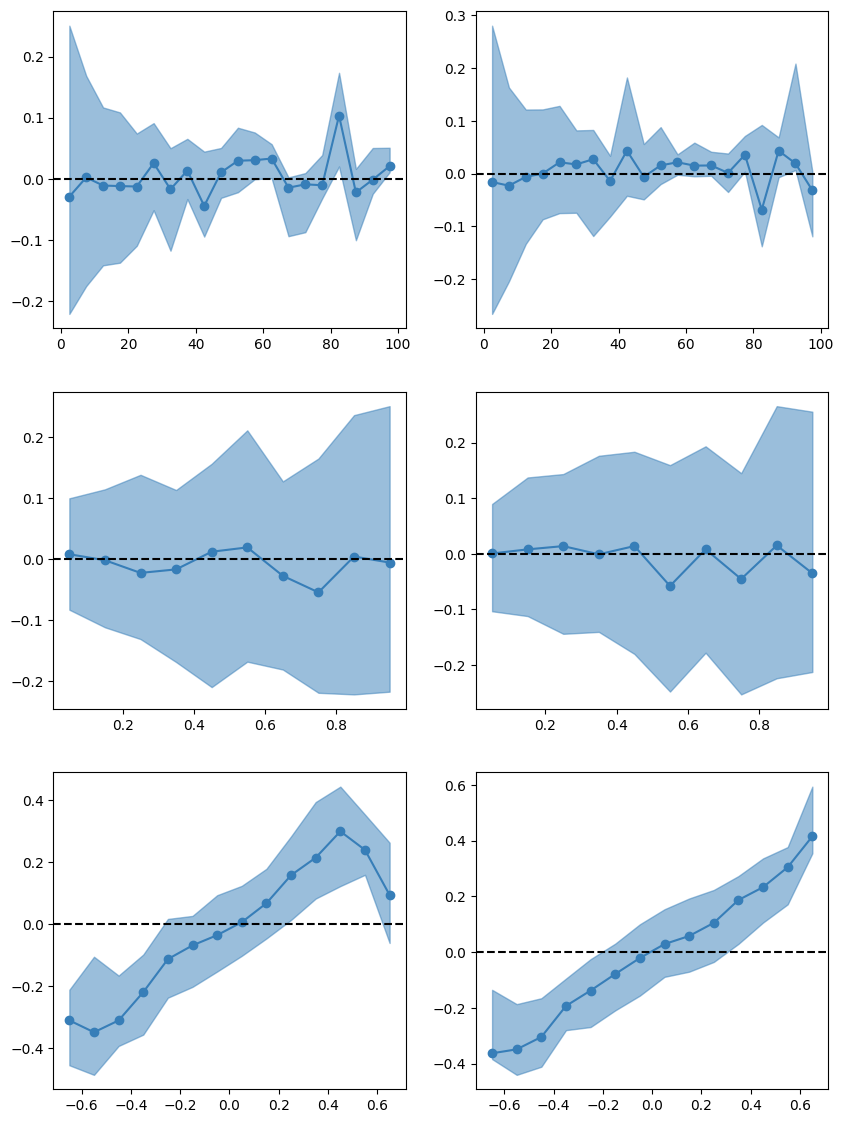

In [ ]:
# combine all plots into one 
fig, axes = plt.subplots(3, 2, figsize=(10, 14))
scatter_shade_plot(axes[0, 0], snr, e11 - e21, (0, 100), delta=5, alpha=0.5)
scatter_shade_plot(axes[0, 1], snr, e12 - e22, (0, 100), delta=5, alpha=0.5)

scatter_shade_plot(axes[1, 0], bdd, e11 - e21, (0, 1), delta=0.1, alpha=0.5)
scatter_shade_plot(axes[1, 1], bdd, e12 - e22, (0, 1), delta=0.1, alpha=0.5)

scatter_shade_plot(axes[2, 0], e11, e11 - e21, (-0.7, 0.7), delta=0.1, alpha=0.5)
scatter_shade_plot(axes[2, 1], e12, e12 - e22, (-0.7, 0.7), delta=0.1, alpha=0.5)

# set vline at 0 for all plots 
for ax in axes.flatten():
    ax.axhline(0, c='k', linestyle='--')
